In [1]:
import pandas as pd
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from datetime import datetime, timedelta
import statsmodels.tsa.api as smt
import calendar
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.rcParams['font.sans-serif']=['SimHei']

In [3]:
df = pd.read_csv('./shanghai_index_1990_12_19_to_2020_03_12.csv')
df.head()

,Timestamp,Price,stock_volume,amount_volume
0,1990/12/19,99.98,1260,494000
1,1990/12/20,104.39,197,84000
2,1990/12/21,109.13,28,16000
3,1990/12/24,114.55,32,31000
4,1990/12/25,120.25,15,6000


In [4]:
df=df[['Timestamp','Price']]

In [5]:
# 将时间作为df的索引
df.Timestamp=pd.to_datetime(df.Timestamp)
df.index=df.Timestamp

In [6]:
# 数据探索
df.head()

,Timestamp,Price
Timestamp,,
1990-12-19,1990-12-19,99.98
1990-12-20,1990-12-20,104.39
1990-12-21,1990-12-21,109.13
1990-12-24,1990-12-24,114.55
1990-12-25,1990-12-25,120.25


In [7]:
# 按照月，季度，年来统计
df_month=df.resample('M').mean()
df_q=df.resample('Q-DEC').mean()
df_year=df.resample('A-DEC').mean()
df_month

,Price
Timestamp,
1990-12-31,116.990000
1991-01-31,132.628182
1991-02-28,131.887778
1991-03-31,126.011429
1991-04-30,118.426818
...,...
2019-11-30,2923.774700
2019-12-31,2962.063709
2020-01-31,3078.654681


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


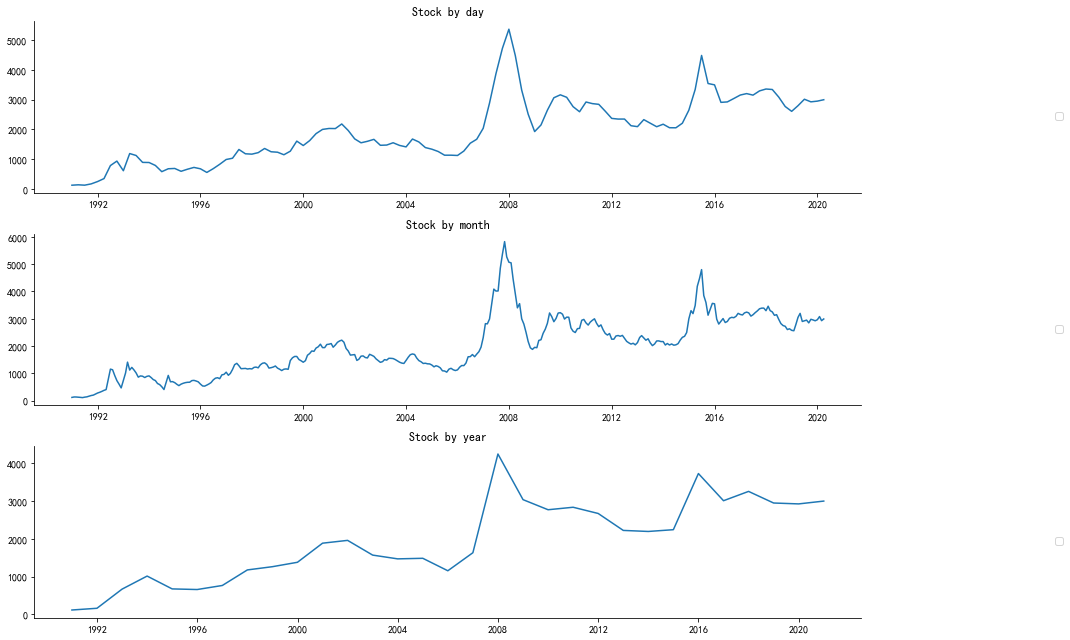

In [8]:
# 画图展示
plt.figure(figsize=(15,9))

plt.subplot(311)
plt.plot(df_q.index,df_q.values)
plt.legend(bbox_to_anchor=(1.25, 0.5))
plt.title("Stock by day")
sns.despine()

plt.subplot(312)
plt.plot(df_month.index,df_month.values)
plt.legend(bbox_to_anchor=(1.25, 0.5))
plt.title("Stock by month")
sns.despine()


plt.subplot(313)
plt.plot(df_year.index,df_year.values)
plt.legend(bbox_to_anchor=(1.25, 0.5))
plt.title("Stock by year")
sns.despine()

plt.tight_layout()
plt.show()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000188F9405F08>,
      dtype=object)

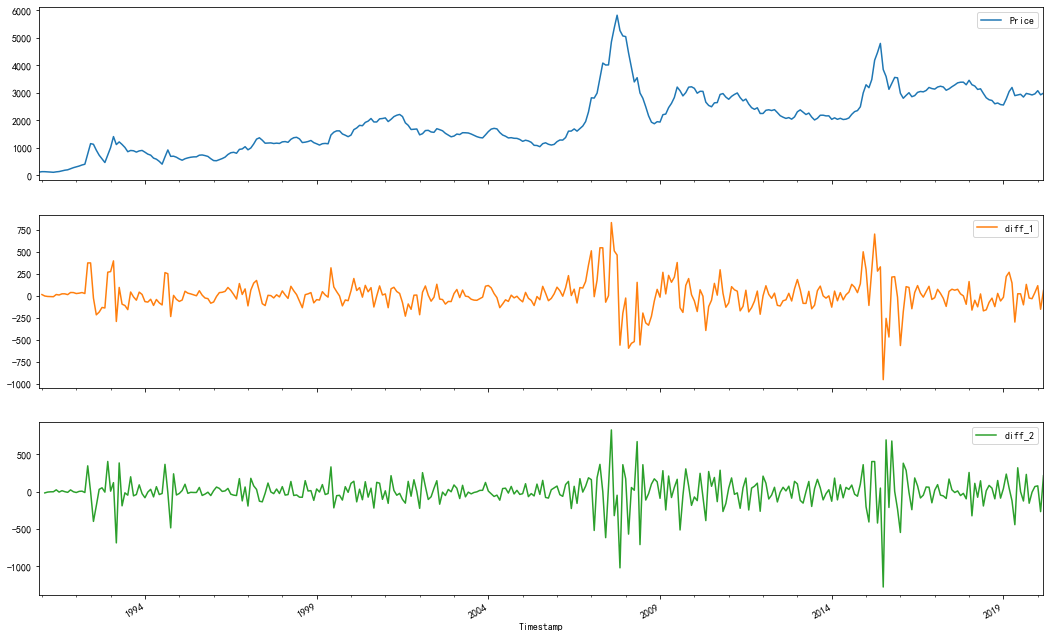

In [9]:
# 查看一阶、二阶方差后的图形结果
df_month['diff_1'] = df_month['Price'].diff(1)

df_month['diff_2'] = df_month['diff_1'].diff(1)

df_month.plot(subplots=True, figsize=(18, 12))

## 图形显示一阶方差，模型会更平稳

In [10]:
# 作图 arima 选择最好的p,q

def tsplot(y, lags=None, title='', figsize=(14, 8)):
   
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax

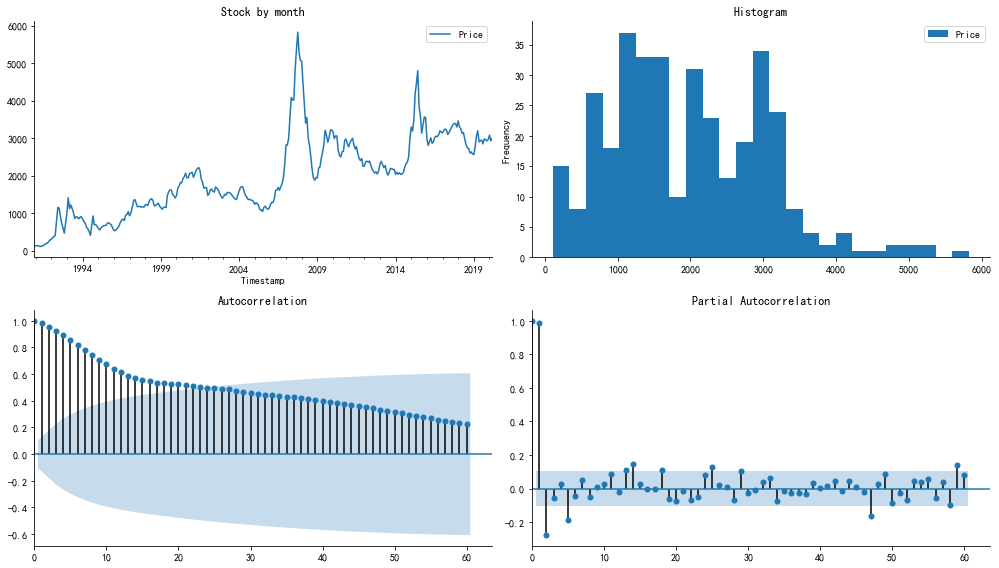

In [11]:
tsplot(df_month[['Price']], title='Stock by month', lags=60);

## 上图中 ,可以看出单独看p,p取1时，效果最好，单独看q,q值（在0-60区间)越大，效果越好,综合来看，在小于15阶时，p=1,q=14效果会更好

In [19]:
# 看看用打擂法是否得出相同结论
# 设置参数范围
ps=range(0,2)
qs=range(0,15) # qs取值1到14
ds=range(1,2)
parameters=product(ps,ds,qs)
parameters_list=list(parameters)

In [20]:
# 寻找最优ARMA模型参数，即best_aic最小
results = []
best_aic = float("inf") # 正无穷
for param in parameters_list:
    try:
        #model = ARIMA(df_month.Price,order=(param[0], param[1], param[2])).fit()
        # SARIMAX 包含季节趋势因素的ARIMA模型
        model = sm.tsa.statespace.SARIMAX(df_month.Price,
                                order=(param[0], param[1], param[2]),
                                #seasonal_order=(4, 1, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit()

    except ValueError:
        print('参数错误:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
# 输出最优模型
print('最优模型: ', best_model.summary())

最优模型:                                 SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  352
Model:              SARIMAX(1, 1, 14)   Log Likelihood               -2177.468
Date:                Sun, 18 Oct 2020   AIC                           4386.937
Time:                        08:58:12   BIC                           4448.010
Sample:                    12-31-1990   HQIC                          4411.282
                         - 03-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6250      0.176      3.561      0.000       0.281       0.969
ma.L1         -0.3250      0.191     -1.702      0.089      -0.699       0.049
ma.L2         -0.0869      0.063     -1.383  

### 上述打擂法算出的最佳模型（p,d,q)中，与作图得出最佳p、d、q结论相符。

In [14]:
# 获取预测的时间 方法1(上课代码)
# 设置future_month,需要预测的时间date_list
df_month2=df_month[['Price']]
future_month=3
last_month=pd.to_datetime(df_month2.index[len(df_month2)-1])
date_list=[]
for i in range(future_month):
    #计算下个月有多少天
    year=last_month.year
    month=last_month.month
    if month==12:
        month=1
        year=year+1
    else:
        month=month+1
    next_month_days=calendar.monthrange(year,month)[1]
    last_month=last_month+timedelta(days=next_month_days)
    date_list.append(last_month)
print('date_list=',date_list)

date_list= [Timestamp('2020-04-30 00:00:00', freq='M'), Timestamp('2020-05-31 00:00:00', freq='M'), Timestamp('2020-06-30 00:00:00', freq='M')]


In [15]:
# 方法2 （简便版）
df_month3=df_month[['Price']]
last_month3=pd.to_datetime(df_month3.index[len(df_month2)-1])
future_month=3
date_list2=pd.date_range(last_month3,periods=future_month+1,freq='M')
date_list2[1:]

DatetimeIndex(['2020-04-30', '2020-05-31', '2020-06-30'], dtype='datetime64[ns]', freq='M')

In [16]:
# 添加未来要预测的3个月
future=pd.DataFrame(index=date_list,columns=df_month.columns)
df_month2=pd.concat([df_month2,future])
df_month2['Price']

1990-12-31     116.990000
1991-01-31     132.628182
1991-02-28     131.887778
1991-03-31     126.011429
1991-04-30     118.426818
                 ...     
2020-02-29    2927.513035
2020-03-31    2990.415289
2020-04-30            NaN
2020-05-31            NaN
2020-06-30            NaN
Name: Price, Length: 355, dtype: float64

In [17]:
# get_prediction 得到的是区间，使用predicted_mean
df_month2['forecast']=best_model.get_prediction(start=0,\
                                        end=len(df_month2)).predicted_mean


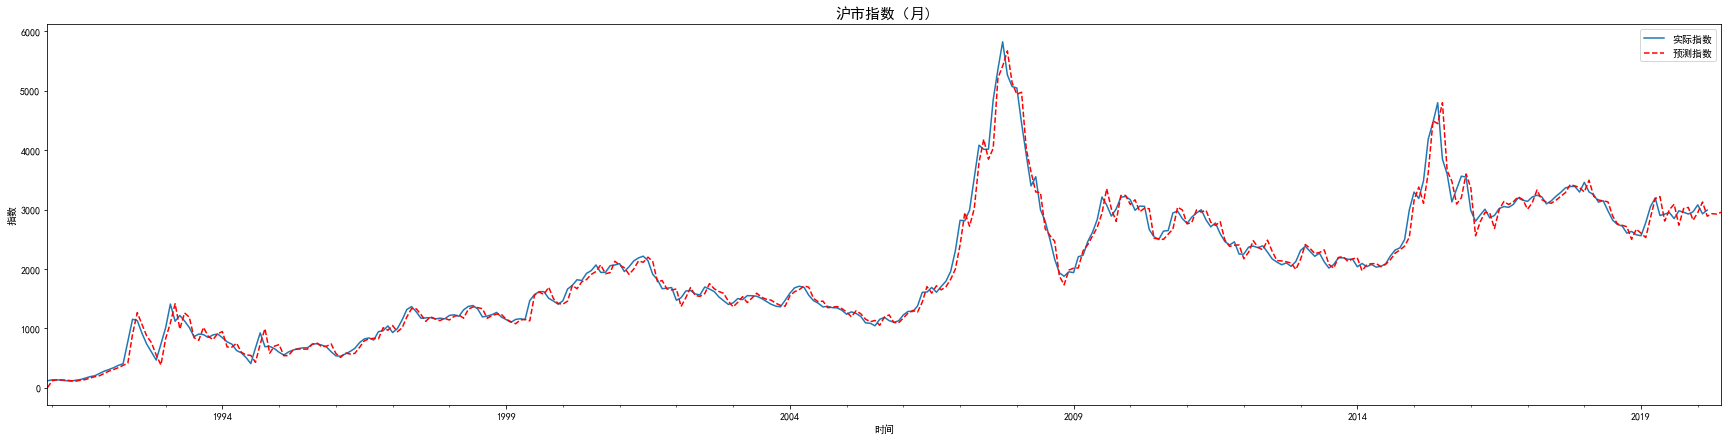

In [18]:
# 沪市指数预测结果显示
plt.figure(figsize=(30,7))
df_month2.Price.plot(label='实际指数')
df_month2.forecast.plot(color='r',ls='--',label='预测指数')
plt.legend()
plt.title('沪市指数（月)',fontsize=15)
plt.xlabel('时间')
plt.ylabel('指数')
plt.show()